<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# CAP-406: Create the MIRI MRS dither patterns #

**Author**: David Law, AURA Associate Astronomer, MIRI branch
<br>
**Last Updated**: June 08, 2021

<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

The purpose of this notebook is to create the MIRI MRS dither patterns from a given set of MRS distortion files using a series of pre-defined algorithms that account for along-slice and across-slice nominal spacing.  The basic idea is as illustrated in this diagram:

<img style="float: center;" src="./assets/diagram.png" alt="stsci_logo" width="500px"/> 

The MRS is sampled in the across-slice direction (beta) by the slice width, and in the along-slice direction (alpha) by the pixel size.  At all wavelengths the observational PSF is undersampled by the slice width, and also by the pixel size at short wavelengths.  Therefore we want to define half-integer offsets between dither positions such that we can improve our sampling frequency.  This is complicated by the fact that the four MRS channels all observe simultaneously, and it takes different offsets to optimize each channel.  However, the MRS slice widths have been carefully chosen such that some offsets can simultaneously achieve half-integer offsets in all channels at once.

As illustrated in the diagram above, the basic idea is that there is a 'long' offset alpha_long and beta_long that samples all channels reasonably while achieving good PSF separation, and a 'short' offset alpha_short and beta_short that helps mitigate the effect of field distortion on our ability to obtain good sampling with the long offsets.  The standard 4-point dither pattern is thus points i, i+1, i+2, i+3 in the above diagram (although not in that order), and this is additionally reflected in parity to include a second pattern i+4, i+5, i+6, i+7.  This basic pattern forms the basis of all point-source optimized dither patterns.  Extended-source dither patterns are also generalized from this concept, but minimize the total offset distance in order to ensure the maximum common field of view between pointings.  For further details see technical report JWST-STScI-005587.

Since the reconstruction of these patterns in the coordinate frame required by the spacecraft requires only a model of the MRS boresight and optical distortion, this CAP can construct it simply using the MRS distortion files.  It therefore reads in the latest distortion files, computes the relevant pixel/slice sizes and field boundaries, and then makes each of the point-source and extended source patterns for all 12 MRS bands.

The actual work of calculating the dither patterns is done in the associated python code makedither_mrs.makepattern_ch1() (and etc).  The majority of this notebook is thus dedicated to rendering various informational plots about what the new dither patterns look like compared to the most recently archived dither patterns (which are included in the miricoord package for reference).

We will determine whether or not the output is acceptable by whether it differs by more than 0.3 arcsec from the pre-flight solution.  Within this range some differences are inevitable as the distortion file is updated in flight.  Larger differences could also be ok if there is a substantial boresight shift in the MRS field locations, but may also indicate a problem with the centroiding of the pattern.  This can be difficult to tell, and if this occurs anyone using this notebook should contact an MRS distortion expert.

The final outputs of this CAP are the plots below (along with some informational JDox figures plotted silently to disk) along with three different dither files: one formatted for the JWST PRD (i.e., to be delivered for flight operations), one formatted for mirisim (i.e., to be delivered to the MIRI instrument simulator), and one with additional details that can be included in a miricoord data directory for future reference and comparison.

<hr style="border:1px solid gray"> </hr>

<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

In [1]:
# Import the required libraries
import os as os
import numpy as np
import datetime
from astropy.io import ascii
from numpy.testing import assert_allclose
import pdb as pdb

from IPython.display import HTML as html_print
from IPython.display import display

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# These functions all require the miricoord package
import miricoord.mrs.mrs_tools as mrst
import miricoord.mrs.makedither.makedither_mrs as mrsd
import miricoord.mrs.makesiaf.makesiaf_mrs as makesiaf

In [2]:
# Define some convenience functions
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
def statustext(status):
    if (status == 0):
        text='OK'
    elif (status == 1):
        text='**WARNING**'
    else:
        text='WARNING'
    return text

def statuscolor(status):
    if (status == 0):
        color='green'
    elif (status == 1):
        color='red'
    else:
        color='black'     
    return color

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def print_color(t):
    display(html_print(' '.join([cstr(ti, color=ci) for ti,ci in t])))

### Output Files ###
Set up where we want the output files to go.  By default, we'll assume that the base directory
$MIRICOORD_DATA_DIR has been define in your .cshrc or .bashrc shell.  If using the standard MIRI Commissioning Box
repository, this might be something like:

setenv MIRIBOX ~/Box/MIRI-COMM/MIRI-COMM-Team<br>
setenv MIRICOORD_DATA_DIR $MIRIBOX/Sandbox/dlaw/miricoord_data_dir/

Output will be written to $MIRICOORD_DATA_DIR/dithers/temp/ by default.

In [3]:
# If the default output directory isn't set by these paths, just use the local directory
if "MIRICOORD_DATA_DIR" in os.environ:
    data_dir=os.getenv('MIRICOORD_DATA_DIR')+'dithers/temp/'
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
else:
    data_dir='./'

In [4]:
# Date with which to mark the new dither files
now=datetime.datetime.now()
nowstring=now.ctime()
nowstring=nowstring[4:8]+nowstring[20:24]

### Previous Dither File ###
Read in the previous set of dithers from the data directory within miricoord.  Note that code required here might change as the old format is updated.

In [5]:
# PRDOPSSOC-M-026.txt is the final pre-flight dither pattern
prevfile=os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/dithers/mrsdither-PRDOPSSOC-M-026.txt')

In [6]:
data=ascii.read(prevfile)
v2_old,v3_old=data['V2'].data,data['V3'].data
v2_old_ch1,v3_old_ch1=v2_old[0:8],v3_old[0:8]
v2_old_ch2,v3_old_ch2=v2_old[8:16],v3_old[8:16]
v2_old_ch3,v3_old_ch3=v2_old[16:24],v3_old[16:24]
v2_old_ch4,v3_old_ch4=v2_old[24:32],v3_old[24:32]
v2_old_eall,v3_old_eall=v2_old[32:36],v3_old[32:36]
v2_old_ech1,v3_old_ech1=v2_old[36:40],v3_old[36:40]
v2_old_ech2,v3_old_ech2=v2_old[40:44],v3_old[40:44]
v2_old_ech3,v3_old_ech3=v2_old[44:48],v3_old[44:48]
v2_old_ech4,v3_old_ech4=v2_old[48:52],v3_old[48:52]

<hr style="border:1px solid gray"> </hr>

<font color='white'>-</font>Calculations<a class="anchor" id="calc"></a>
------------------

### Define the distortion files to use to create the new dither pattern ###

In [7]:
# Here we'll use FLT-1, but this will need to be updated as necessary.
# We rely on the distortion files being properly imported into miricoord first as part of the delivery
# of the distortion files earlier in commissioning.
mrst.set_toolversion('flt1')
mrst.version()

'flt1'

In [8]:
# Define the field boundaries used by the SIAF
# We create all of this anew instead of simply reading the SIAF because
# sometimes it takes a long time to get the SIAF PRD updated
siaf1A=makesiaf.create_siaf_oneband('1A')
siaf1B=makesiaf.create_siaf_oneband('1B')
siaf1C=makesiaf.create_siaf_oneband('1C')

siaf2A=makesiaf.create_siaf_oneband('2A')
siaf2B=makesiaf.create_siaf_oneband('2B')
siaf2C=makesiaf.create_siaf_oneband('2C')

siaf3A=makesiaf.create_siaf_oneband('3A')
siaf3B=makesiaf.create_siaf_oneband('3B')
siaf3C=makesiaf.create_siaf_oneband('3C')

siaf4A=makesiaf.create_siaf_oneband('4A')
siaf4B=makesiaf.create_siaf_oneband('4B')
siaf4C=makesiaf.create_siaf_oneband('4C')

### Calculate actual pixel sizes and slice widths ###

In [9]:
# This sets the pixel and slice sizes in a GLOBAL variable
mrsd.setsizes(verbose=1)

Slice widths:  [0.17721014 0.27971819 0.38981378 0.65603803]
Pixel sizes:  [0.19058661 0.19448411 0.25188681 0.26938074]


### Set up a status descriptors ###

In [10]:
# We'll set up variables to track the status of each set of dither patterns
# so that we can summarize the results at the end of this notebook.
# 0=good, 1=bad, default is BAD

status_pt_ch1=1
status_pt_ch2=1
status_pt_ch3=1
status_pt_ch4=1

status_ex_all=1
status_ex_ch1=1
status_ex_ch2=1
status_ex_ch3=1
status_ex_ch4=1

Now construct and evaluate each dither pattern.

### Ch1 point-source dithers ###

In [11]:
v2_ch1,v3_ch1=mrsd.makepattern_ch1(siaf1A,siaf1B,siaf1C)

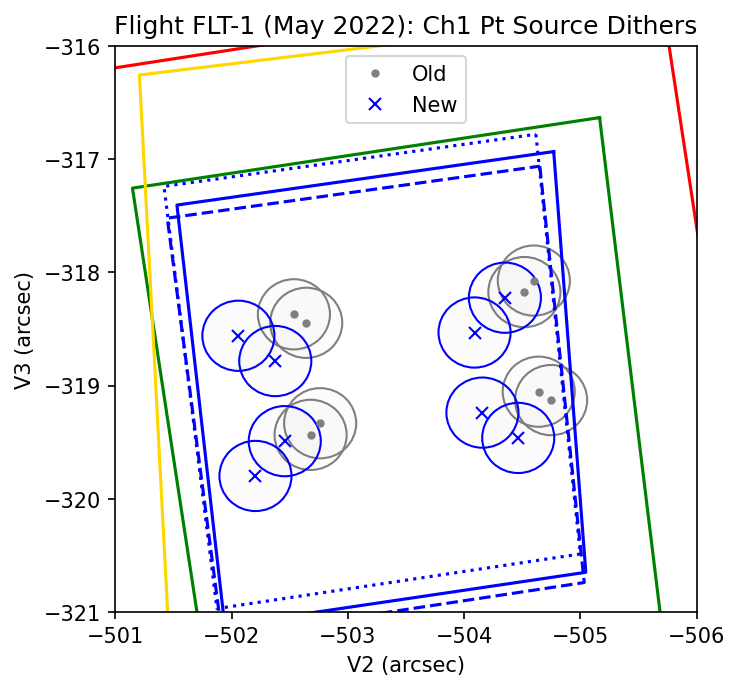

In [12]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()
plt.xlim(-501,-506)
plt.ylim(-321,-316)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')
    
plt.plot(v2_old_ch1,v3_old_ch1,'.',color='gray',label='Old')
for i in range(0,v2_old_ch1.size):
    circle1 = mpl.patches.Circle((v2_old_ch1[i], v3_old_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch1,v3_ch1,'x',color='b',label='New')
for i in range(0,v2_ch1.size):
    circle1 = mpl.patches.Circle((v2_ch1[i], v3_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf1B['inscr_v2_corners'],siaf1B['inscr_v3_corners'],'--',color='b',linewidth=1.5)
plt.plot(siaf1C['inscr_v2_corners'],siaf1C['inscr_v3_corners'],':',color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ch1 Pt Source Dithers')
plt.legend()

In [13]:
# Test that they didn't change too much
diff = np.sqrt((v2_ch1-v2_old_ch1)**2 + (v3_ch1-v3_old_ch1)**2)
if (np.max(diff) > 0.3):
    status_pt_ch1=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_pt_ch1=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Ch2 point-source dithers ###

In [14]:
v2_ch2,v3_ch2=mrsd.makepattern_ch2(siaf2A,siaf2B,siaf2C)

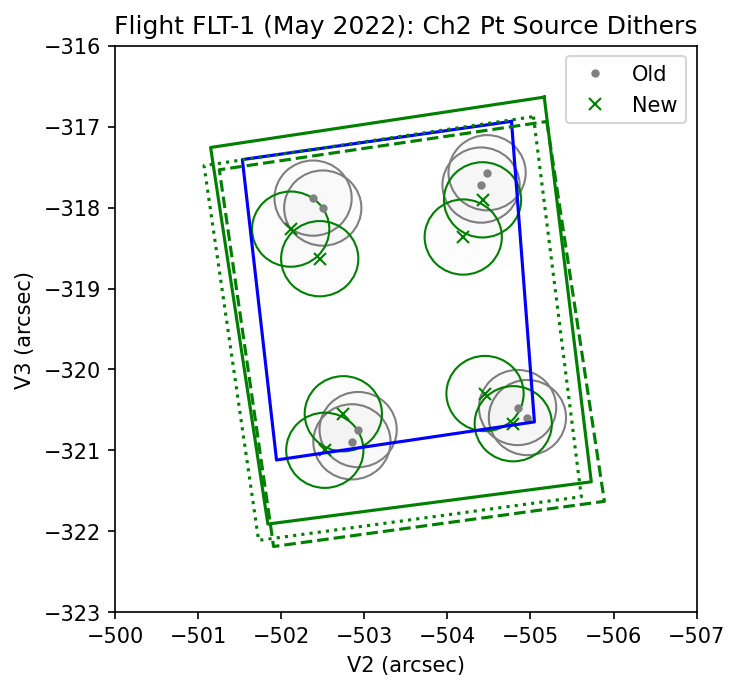

In [15]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-500,-507)
plt.ylim(-323,-316)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ch2,v3_old_ch2,'.',color='gray',label='Old')
for i in range(0,v2_old_ch2.size):
    circle1 = mpl.patches.Circle((v2_old_ch2[i], v3_old_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch2,v3_ch2,'x',color='g',label='New')
for i in range(0,v2_ch2.size):
    circle1 = mpl.patches.Circle((v2_ch2[i], v3_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='g', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)  
    
plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf2B['inscr_v2_corners'],siaf2B['inscr_v3_corners'],'--',color='g',linewidth=1.5)
plt.plot(siaf2C['inscr_v2_corners'],siaf2C['inscr_v3_corners'],':',color='g',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ch2 Pt Source Dithers')
plt.legend()

In [16]:
# Test that they didn't change too much
diff = np.sqrt((v2_ch2-v2_old_ch2)**2 + (v3_ch2-v3_old_ch2)**2)
if (np.max(diff) > 0.3):
    status_pt_ch2=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_pt_ch2=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Ch3 point-source dithers ###

In [17]:
v2_ch3,v3_ch3=mrsd.makepattern_ch3(siaf3A,siaf3B,siaf3C)

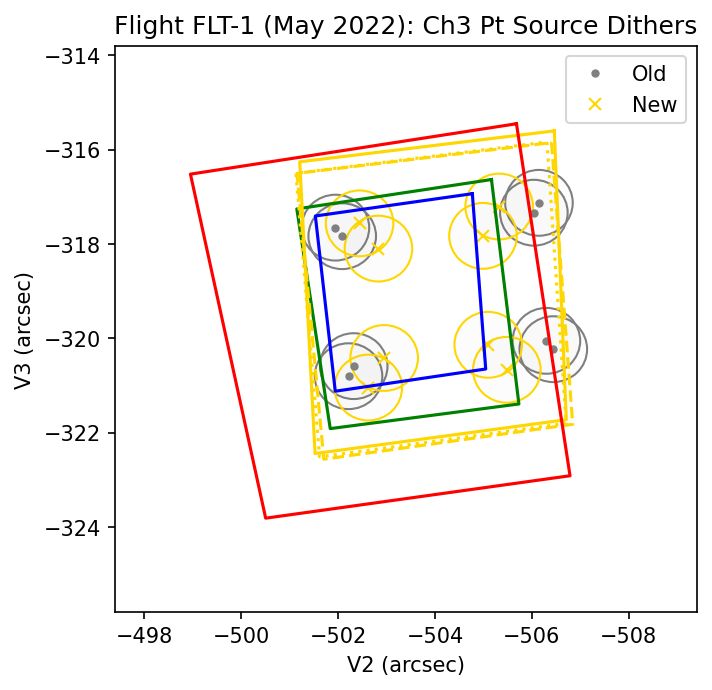

In [18]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ch3,v3_old_ch3,'.',color='gray',label='Old')
for i in range(0,v2_old_ch3.size):
    circle1 = mpl.patches.Circle((v2_old_ch3[i], v3_old_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch3,v3_ch3,'x',color='gold',label='New')
for i in range(0,v2_ch3.size):
    circle1 = mpl.patches.Circle((v2_ch3[i], v3_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='gold', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)  
    
plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf3B['inscr_v2_corners'],siaf3B['inscr_v3_corners'],'--',color='gold',linewidth=1.5)
plt.plot(siaf3C['inscr_v2_corners'],siaf3C['inscr_v3_corners'],':',color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ch3 Pt Source Dithers')
plt.legend()

In [19]:
# Test that they didn't change too much
diff = np.sqrt((v2_ch3-v2_old_ch3)**2 + (v3_ch3-v3_old_ch3)**2)
if (np.max(diff) > 0.3):
    status_pt_ch3=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_pt_ch3=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Ch4 point-source dithers ###

In [20]:
v2_ch4,v3_ch4=mrsd.makepattern_ch4(siaf4A,siaf4B,siaf4C)

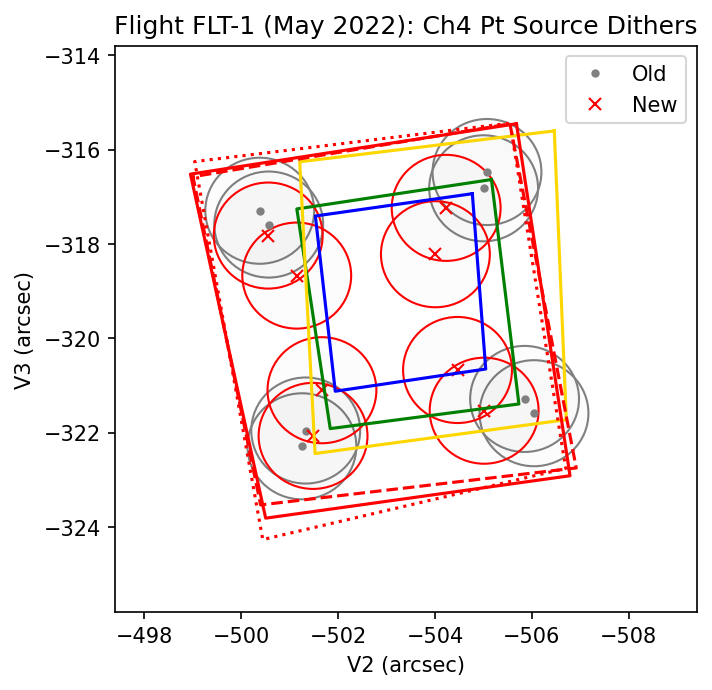

In [21]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ch4,v3_old_ch4,'.',color='gray',label='Old')
for i in range(0,v2_old_ch4.size):
    circle1 = mpl.patches.Circle((v2_old_ch4[i], v3_old_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ch4,v3_ch4,'x',color='r',label='New')
for i in range(0,v2_ch4.size):
    circle1 = mpl.patches.Circle((v2_ch4[i], v3_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='r', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.plot(siaf4B['inscr_v2_corners'],siaf4B['inscr_v3_corners'],'--',color='r',linewidth=1.5)
plt.plot(siaf4C['inscr_v2_corners'],siaf4C['inscr_v3_corners'],':',color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ch4 Pt Source Dithers')
plt.legend()

In [22]:
# Test that they didn't change too much
diff = np.sqrt((v2_ch4-v2_old_ch4)**2 + (v3_ch4-v3_old_ch4)**2)
if (np.max(diff) > 0.3):
    status_pt_ch4=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_pt_ch4=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Make the extended source patterns ###

In [23]:
v2_ext_all,v3_ext_all=mrsd.makepattern_ext_all(siaf1A,siaf1B,siaf1C)
v2_ext_ch1,v3_ext_ch1=mrsd.makepattern_ext_ChX(v2_ch1,v3_ch1,siaf1A)
v2_ext_ch2,v3_ext_ch2=mrsd.makepattern_ext_ChX(v2_ch2,v3_ch2,siaf2A)
v2_ext_ch3,v3_ext_ch3=mrsd.makepattern_ext_ChX(v2_ch3,v3_ch3,siaf3A)
v2_ext_ch4,v3_ext_ch4=mrsd.makepattern_ext_ChX(v2_ch4,v3_ch4,siaf4A)

### Extended source ALL dithers ###

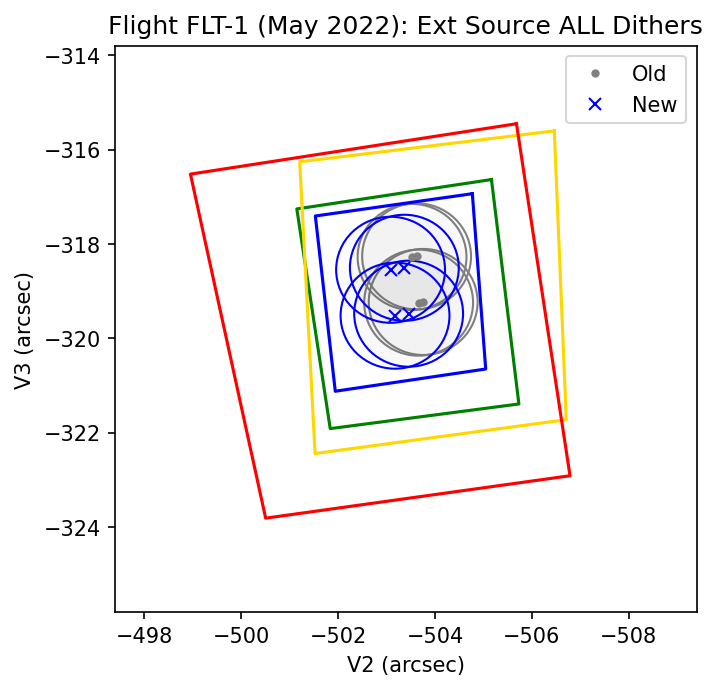

In [24]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_eall,v3_old_eall,'.',color='gray',label='Old')
for i in range(0,v2_old_eall.size):
    circle1 = mpl.patches.Circle((v2_old_eall[i], v3_old_eall[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_all,v3_ext_all,'x',color='b',label='New')
for i in range(0,v2_ext_all.size):
    circle1 = mpl.patches.Circle((v2_ext_all[i], v3_ext_all[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ext Source ALL Dithers')
plt.legend()

In [25]:
# Test that they didn't change too much
diff = np.sqrt((v2_ext_all-v2_old_eall)**2 + (v3_ext_all-v3_old_eall)**2)
if (np.max(diff) > 0.3):
    status_ex_all=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_ex_all=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Extended source Ch1 dithers ###

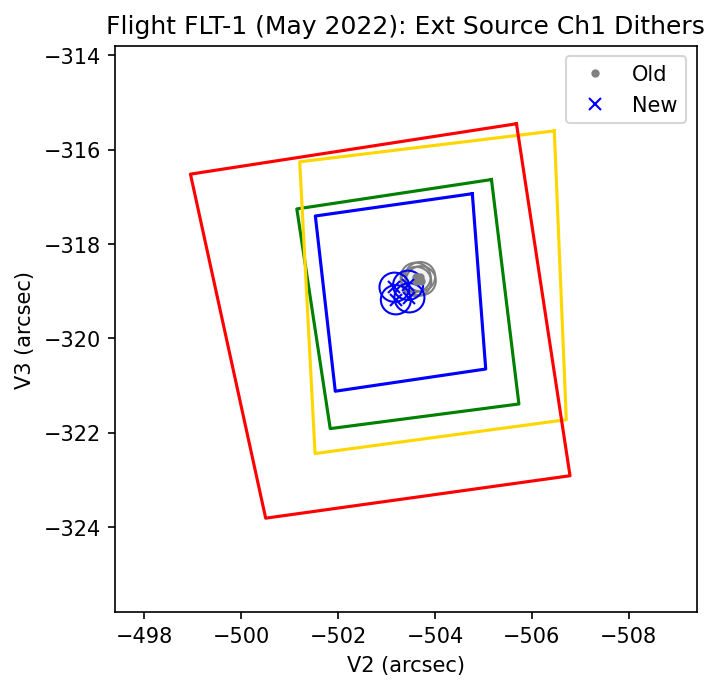

In [26]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech1,v3_old_ech1,'.',color='gray',label='Old')
for i in range(0,v2_old_ech1.size):
    circle1 = mpl.patches.Circle((v2_old_ech1[i], v3_old_ech1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch1,v3_ext_ch1,'x',color='b',label='New')
for i in range(0,v2_ext_ch1.size):
    circle1 = mpl.patches.Circle((v2_ext_ch1[i], v3_ext_ch1[i]), mrsd.maxfwhm(1),linewidth=1,edgecolor='b', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ext Source Ch1 Dithers')
plt.legend()

In [27]:
# Test that they didn't change too much
diff = np.sqrt((v2_ext_ch1-v2_old_ech1)**2 + (v3_ext_ch1-v3_old_ech1)**2)
if (np.max(diff) > 0.3):
    status_ex_ch1=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_ex_ch1=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Extended source Ch2 dithers ###

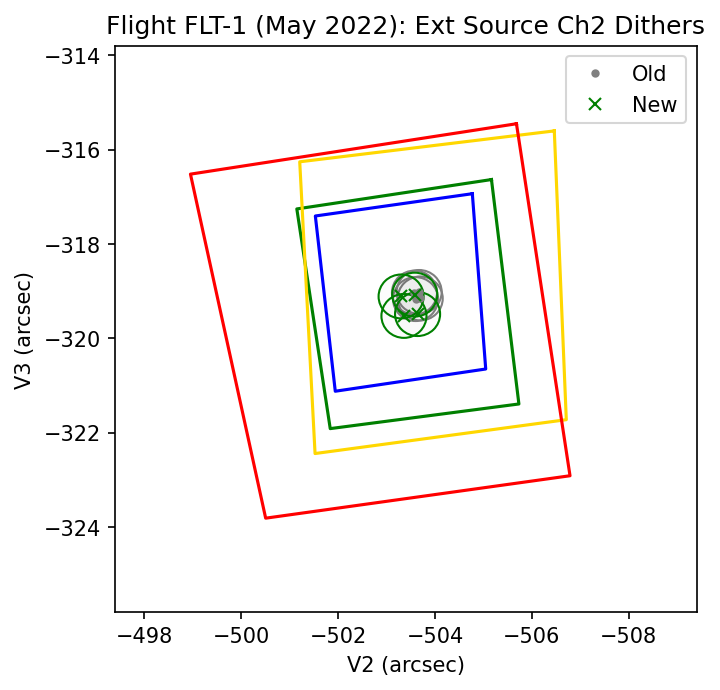

In [28]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech2,v3_old_ech2,'.',color='gray',label='Old')
for i in range(0,v2_old_ech2.size):
    circle1 = mpl.patches.Circle((v2_old_ech2[i], v3_old_ech2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch2,v3_ext_ch2,'x',color='g',label='New')
for i in range(0,v2_ext_ch2.size):
    circle1 = mpl.patches.Circle((v2_ext_ch2[i], v3_ext_ch2[i]), mrsd.maxfwhm(2),linewidth=1,edgecolor='g', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ext Source Ch2 Dithers')
plt.legend()

In [29]:
# Test that they didn't change too much
diff = np.sqrt((v2_ext_ch2-v2_old_ech2)**2 + (v3_ext_ch2-v3_old_ech2)**2)
if (np.max(diff) > 0.3):
    status_ex_ch2=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_ex_ch2=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Extended source Ch3 dithers ###

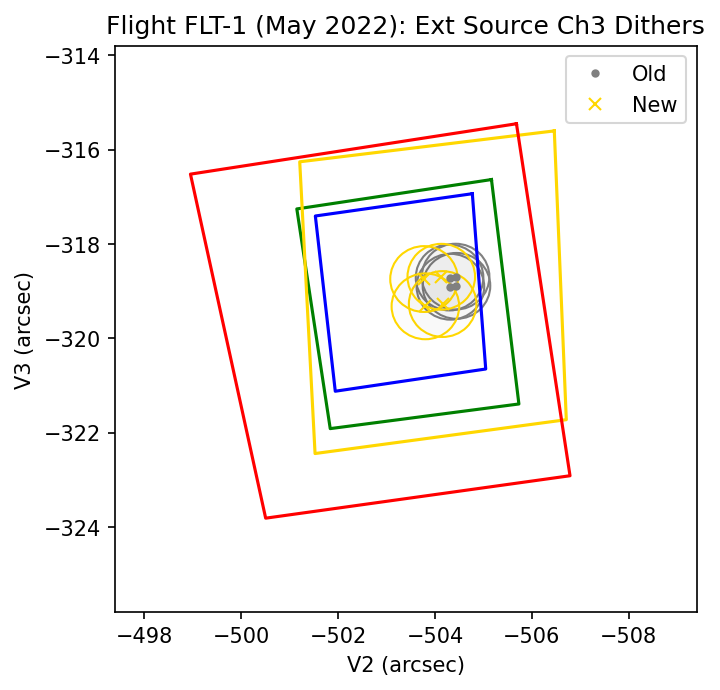

In [30]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech3,v3_old_ech3,'.',color='gray',label='Old')
for i in range(0,v2_old_ech3.size):
    circle1 = mpl.patches.Circle((v2_old_ech3[i], v3_old_ech3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch3,v3_ext_ch3,'x',color='gold',label='New')
for i in range(0,v2_ext_ch3.size):
    circle1 = mpl.patches.Circle((v2_ext_ch3[i], v3_ext_ch3[i]), mrsd.maxfwhm(3),linewidth=1,edgecolor='gold', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ext Source Ch3 Dithers')
plt.legend()

In [31]:
# Test that they didn't change too much
diff = np.sqrt((v2_ext_ch3-v2_old_ech3)**2 + (v3_ext_ch3-v3_old_ech3)**2)
if (np.max(diff) > 0.3):
    status_ex_ch3=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_ex_ch3=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Extended source Ch4 dithers ###

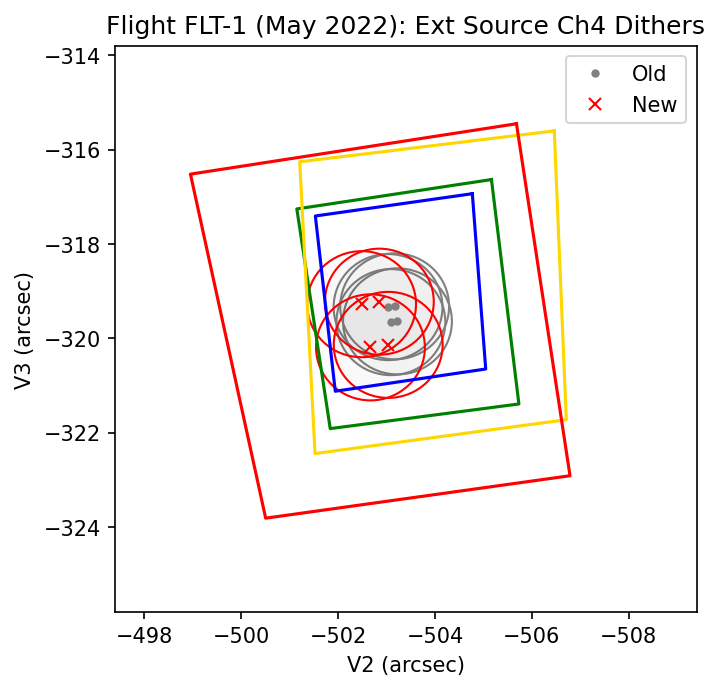

In [32]:
plt.figure(figsize=(5,5),dpi=150)
ax = plt.gca()

plt.xlim(-497.4,-509.4)
plt.ylim(-325.8,-313.8)
plt.xlabel('V2 (arcsec)')
plt.ylabel('V3 (arcsec)')

plt.plot(v2_old_ech4,v3_old_ech4,'.',color='gray',label='Old')
for i in range(0,v2_old_ech4.size):
    circle1 = mpl.patches.Circle((v2_old_ech4[i], v3_old_ech4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='gray', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)    

plt.plot(v2_ext_ch4,v3_ext_ch4,'x',color='r',label='New')
for i in range(0,v2_ext_ch4.size):
    circle1 = mpl.patches.Circle((v2_ext_ch4[i], v3_ext_ch4[i]), mrsd.maxfwhm(4),linewidth=1,edgecolor='r', facecolor=(0, 0, 0, .0125))
    ax.add_artist(circle1)

plt.plot(siaf1A['inscr_v2_corners'],siaf1A['inscr_v3_corners'],color='b',linewidth=1.5)
plt.plot(siaf2A['inscr_v2_corners'],siaf2A['inscr_v3_corners'],color='g',linewidth=1.5)
plt.plot(siaf3A['inscr_v2_corners'],siaf3A['inscr_v3_corners'],color='gold',linewidth=1.5)
plt.plot(siaf4A['inscr_v2_corners'],siaf4A['inscr_v3_corners'],color='r',linewidth=1.5)
plt.title('Flight FLT-1 ('+nowstring+'): Ext Source Ch4 Dithers')
plt.legend()

In [33]:
# Test that they didn't change too much
diff = np.sqrt((v2_ext_ch4-v2_old_ech4)**2 + (v3_ext_ch4-v3_old_ech4)**2)
if (np.max(diff) > 0.3):
    status_ex_ch4=1
    printmd('**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?', color="red")
else:
    status_ex_ch4=0
    printmd('**Looks OK!**', color="green")

<span style='color:red'>**WARNING**: Dithers have changed by > 0.3 arcsec, are you sure this was intentional?</span>

### Put all of the patterns together and compute Ideal frame offsets ###

In [34]:
# So far each of these gave specific v2/v3 pointing locations.
# Now they need to be converted to xidl, yidl offsets relative to the pointing origin for a given dither pattern
# (i.e., where the undithered pointing is for a given channel)
# Note that this means the offsets (wrt A band) won't necessarily be symmetric around 0 xideal/yideal because
# they average over the FoV of bands A/B/C together.

In [35]:
# Positions index
index=np.arange(52)+1

# Ch1 point source pattern
v2_all,v3_all=v2_ch1,v3_ch1
ch_all=(np.ones(len(v2_ch1))).astype(int)
dx,dy=mrsd.compute_dxdyideal(v2_ch1,v3_ch1,siaf1A,siaf1A=siaf1A)
dx_all,dy_all=dx,dy
# Ch2 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch2),np.append(v3_all,v3_ch2)
ch_all=np.append(ch_all,(np.ones(len(v2_ch2))*2).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch2,v3_ch2,siaf2A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Ch3 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch3),np.append(v3_all,v3_ch3)
ch_all=np.append(ch_all,(np.ones(len(v2_ch3))*3).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch3,v3_ch3,siaf3A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Ch4 point source pattern
v2_all,v3_all=np.append(v2_all,v2_ch4),np.append(v3_all,v3_ch4)
ch_all=np.append(ch_all,(np.ones(len(v2_ch4))*4).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ch4,v3_ch4,siaf4A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)

# Extended source ALL pattern
v2_all,v3_all=np.append(v2_all,v2_ext_all),np.append(v3_all,v3_ext_all)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_all))).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_all,v3_ext_all,siaf1A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch1 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch1),np.append(v3_all,v3_ext_ch1)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch1))).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch1,v3_ext_ch1,siaf1A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch2 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch2),np.append(v3_all,v3_ext_ch2)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch2))*2).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch2,v3_ext_ch2,siaf2A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch3 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch3),np.append(v3_all,v3_ext_ch3)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch3))*3).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch3,v3_ext_ch3,siaf3A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)
# Extended source Ch4 pattern
v2_all,v3_all=np.append(v2_all,v2_ext_ch4),np.append(v3_all,v3_ext_ch4)
ch_all=np.append(ch_all,(np.ones(len(v2_ext_ch4))*4).astype(int))
dx,dy=mrsd.compute_dxdyideal(v2_ext_ch4,v3_ext_ch4,siaf4A,siaf1A=siaf1A)
dx_all,dy_all=np.append(dx_all,dx),np.append(dy_all,dy)

### Generate QA plots for JDox ###

In [36]:
# Now generate the usual suite of figures for JDox.  These are not relevant for evaluating the CAP
# success, so we'll create these plots quietly in the background.
allsiaf=[siaf1A,siaf1B,siaf1C,siaf2A,siaf2B,siaf2C,siaf3A,siaf3B,siaf3C,siaf4A,siaf4B,siaf4C]
mrsd.make_jdox(v2_all,v3_all,dx_all,dy_all,allsiaf,outdir=data_dir)

### Write results to disk ###

In [37]:
mrsd.writeresults_mirisim(ch_all,v2_all,v3_all,outdir=data_dir)
mrsd.writeresults_prd(dx_all,dy_all,outdir=data_dir)
mrsd.writeresults_full(index,ch_all,v2_all,v3_all,dx_all,dy_all,outdir=data_dir)

Successfully wrote mirisim dithers file to  mrs_recommended_dither.dat
Successfully wrote PRD dithers file to  MiriMrsDithers.txt
Successfully wrote full dithers file to  mrs_dithers.txt


### Summarize results ###

In [38]:
# Print results for each MRS dither pattern
print_color((('Point source pattern for Ch1:', 'black'),(statustext(status_pt_ch1),statuscolor(status_pt_ch1))))
print_color((('Point source pattern for Ch2:', 'black'),(statustext(status_pt_ch2),statuscolor(status_pt_ch2))))
print_color((('Point source pattern for Ch3:', 'black'),(statustext(status_pt_ch3),statuscolor(status_pt_ch3))))
print_color((('Point source pattern for Ch4:', 'black'),(statustext(status_pt_ch4),statuscolor(status_pt_ch4))))

print_color((('Extended source pattern for ALL channels:', 'black'),(statustext(status_ex_all),statuscolor(status_ex_all))))
print_color((('Extended source pattern for Ch1:', 'black'),(statustext(status_ex_ch1),statuscolor(status_ex_ch1))))
print_color((('Extended source pattern for Ch2:', 'black'),(statustext(status_ex_ch2),statuscolor(status_ex_ch2))))
print_color((('Extended source pattern for Ch3:', 'black'),(statustext(status_ex_ch3),statuscolor(status_ex_ch3))))
print_color((('Extended source pattern for Ch4:', 'black'),(statustext(status_ex_ch4),statuscolor(status_ex_ch4))))

In [39]:
# Print a final summary recommendation (ok or not ok)
allstatus=[status_pt_ch1,status_pt_ch2,status_pt_ch3,status_pt_ch4,status_ex_all,status_ex_ch1, \
          status_ex_ch2,status_ex_ch3,status_ex_ch4]

if (np.sum(allstatus) == 0):
    print_color((('Everything looks ok!', 'green'),))

if (np.sum(allstatus) != 0):
    print_color((('**Warning**, at least one pattern deviates from the previous pattern more than expected!', 'red'),))
    print_color((('Please consult an expert.', 'red'),))


<img style="float: center;" src="./assets/stsci_logo.png" alt="stsci_logo" width="200px"/> 